In [5]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

## Load Dataset

In [9]:
df = pd.read_csv("../data/raw_analyst_ratings.csv", parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
if df['date'].dt.tz is None:
    df['date'] = df['date'].dt.tz_localize('Etc/GMT+4')

print('rows: ', len(df))
df.head()

rows:  1407328


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A


## EDA

**Descriptive Statistics**

In [10]:
# Statistics on headline lengths
df["headline_len"] = df["headline"].str.len()
print(df["headline_len"].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len, dtype: float64


In [15]:
# article per publisher
pub_counts = df["publisher"].value_counts().reset_index()
pub_counts
pub_counts.columns = ["publisher", "article_count"]
print(pub_counts.head(15))

            publisher  article_count
0       Paul Quintaro         228373
1          Lisa Levin         186979
2   Benzinga Newsdesk         150484
3       Charles Gross          96732
4       Monica Gerson          82380
5        Eddie Staley          57254
6          Hal Lindon          49047
7       ETF Professor          28489
8          Juan Lopez          28438
9      Benzinga Staff          28114
10         Vick Meyer          24826
11          webmaster          20313
12  Benzinga_Newsdesk          19410
13              Zacks          19390
14     Jayson Derrick          19050


<Axes: title={'center': 'Articles per Day'}, xlabel='date'>

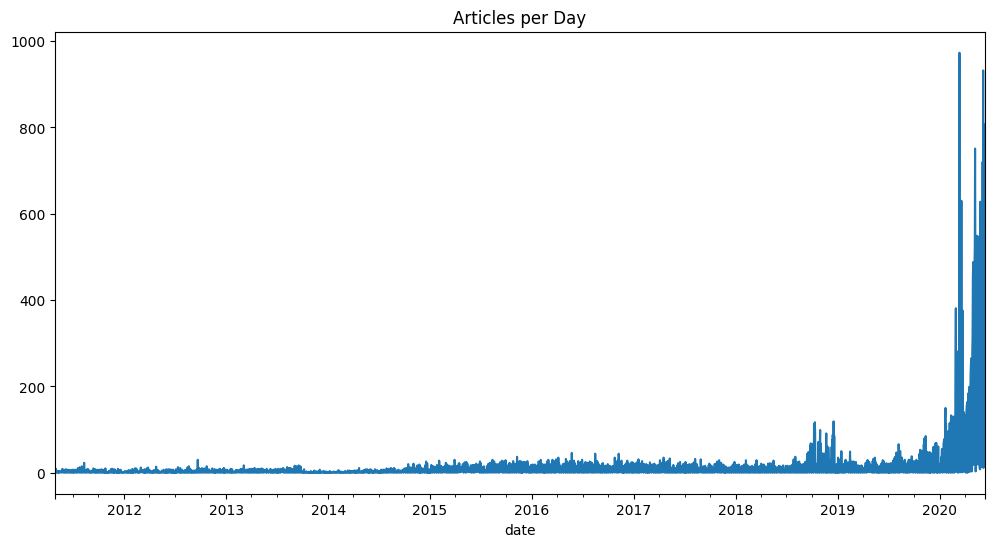

In [16]:
# publications over time (daily)
daily = df.set_index('date').resample('D').size()
daily.plot(title='Articles per Day', figsize=(12,6))

**Text Analysis**

In [20]:
import re
import nltk
from nltk.corpus import stopwords
import spacy

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Abel
[nltk_data]     Tesfa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [24]:
stop = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm', disable=['ner'])

In [27]:
def clean_text(text):
    t = str(text)
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^0-9A-Za-z']+", ' ', t)
    t = t.lower()
    return t

In [28]:
df['clean_headline'] = df['headline'].fillna('').apply(clean_text)


def token_count(text):
    return len([w for w in text.split() if w not in stop])

df['token_count'] = df['clean_headline'].apply(token_count)
print(df[['headline', 'clean_headline', 'token_count']].head())

                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                      clean_headline  token_count  
0            stocks that hit 52 week highs on friday            6  
1         stocks that hit 52 week highs on wednesday            6  
2                      71 biggest movers from friday            4  
3       46 stocks moving in friday's mid day session            7  
4  b of a securities maintains neutral on agilent...           10  


**Topic Modeling**

In [31]:
# topic keywords -- simple frequent phrases
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2), max_features=2000, stop_words='english')
X = vectorizer.fit_transform(df['clean_headline'])
terms = vectorizer.get_feature_names_out()
freq = np.asarray(X.sum(axis=0)).ravel()
kw = pd.DataFrame({'term':terms,'count':freq}).sort_values('count', ascending=False)
kw.head(50)

,term,count
1906,vs,162099
1732,stocks,161776
698,est,140632
655,eps,128897
1098,market,120559
1647,shares,114313
1508,reports,108710
1866,update,91722
619,earnings,87399
1572,sales,79645


**Sentiment Scoring**

In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


def vader_score(text):
    s = analyzer.polarity_scores(text)
    return s['compound']

# Apply to dataframe
sample = df.sample(2000, random_state=42) if len(df) > 2000 else df
sample['vader'] = sample['headline'].apply(vader_score)

# results
sample[['headline', 'vader']].head()

,headline,vader
1201723,"Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...",0.0000
1282616,Mid-Day Market Update: K2M Group Rises On Acqu...,0.2960
554075,Aramchol's Failed Past Isn't Its Future; Galme...,-0.5106
1190332,60 Stocks Moving In Thursday's Mid-Day Session,0.0000
192958,Anheuser-Busch shares are trading lower after ...,0.0000


## Time Series Analysis

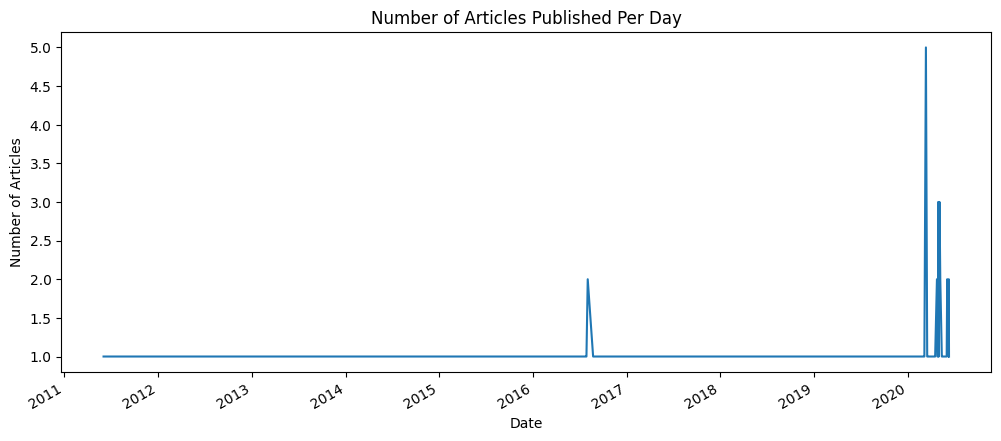

In [34]:
# Daily publication counts (per day)
sample['pub_date'] = sample['date'].dt.normalize()  # normalize to day
daily_counts = sample.groupby('pub_date').size()

plt.figure(figsize=(12,5))
daily_counts.plot()
plt.title('Number of Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

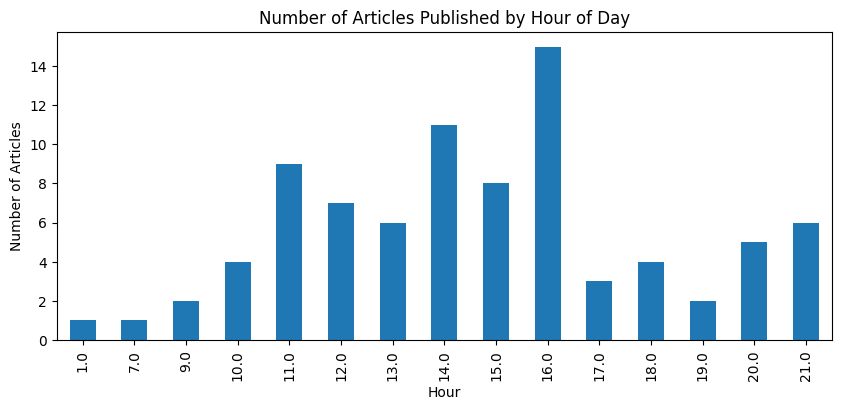

In [35]:
# Hourly distribution of publication (what time of day most news is released)
sample['hour'] = sample['date'].dt.hour
hourly_counts = sample.groupby('hour').size()

plt.figure(figsize=(10,4))
hourly_counts.plot(kind='bar')
plt.title('Number of Articles Published by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.show()

## Publication Analysis

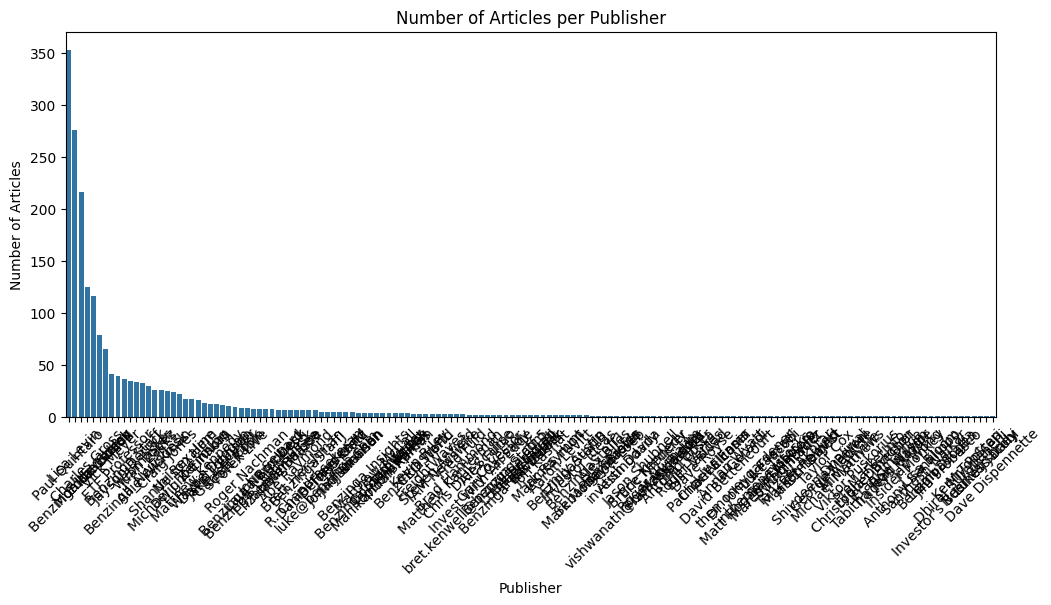

In [38]:
import seaborn as sns
publisher_counts = sample['publisher'].value_counts()

plt.figure(figsize=(12,5))
sns.barplot(x=publisher_counts.index, y=publisher_counts.values)
plt.xticks(rotation=45)
plt.title('Number of Articles per Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.show()